# CudaMS

This notebook closely follows the original [matchms tutorial](https://blog.esciencecenter.nl/build-your-own-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-i-d96c718c68ee), but uses our custom CUDA kernel to calculate the CosineGreedy similarity between given pesticide spectra.

For convenience, we are using a colab environment - so that you can run everything in browser.

# Selecting the correct runtime (to access CUDA-enabled GPU)

To compile and use the CUDA kernel, you **need to use a GPU**. To request a free GPU from colab, follow these steps:

In the top right click the black triangle:



![image.png](https://github.com/tornikeo/cudams/blob/main/assets/samples/colab_tutorial_pesticide/step1.png?raw=true)

Click "Change runtime type"

![image-2.png](https://github.com/tornikeo/cudams/blob/main/assets/samples/colab_tutorial_pesticide/step2.png?raw=true)

Click "T4 GPU":

![image-3.png](https://github.com/tornikeo/cudams/blob/main/assets/samples/colab_tutorial_pesticide/step3.png?raw=true)

Click "OK" on "Disconnect and delete runtime" (we haven't done much yet, so this is OK)

![image-4.png](https://github.com/tornikeo/cudams/blob/main/assets/samples/colab_tutorial_pesticide/step4.png?raw=true)

Click "Save"

![image-5.png](https://github.com/tornikeo/cudams/blob/main/assets/samples/colab_tutorial_pesticide/step5.png?raw=true)

Now you can compile the cuda kernel, and use the `CudaCosineGreedy` just like you would the `CosineGreedy`.

![image-6.png](https://github.com/tornikeo/cudams/blob/main/assets/samples/colab_tutorial_pesticide/step6.png?raw=true)

In [47]:
gpu = ! nvidia-smi
assert 'Tesla T4' in '\n'.join(gpu)
print('\n'.join(gpu))

Wed Mar 27 12:10:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0              27W /  70W |   1447MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Install the `cudams` package from github. This can take 2-3 minutes.

In [48]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

! pip uninstall cudams -q -y
! pip install -q git+https://github.com/tornikeo/cudams.git@dev
! pip install -U ipykernel

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [49]:
from numba import cuda
assert cuda.is_available(), "Change the colab instance type to T4. See guide above (^)"

Import relevant methods and libraries.


In [50]:
%%capture
import warnings
warnings.filterwarnings('ignore')
from matchms.importing import load_from_mgf
from matchms.filtering import default_filters, reduce_to_number_of_peaks
from matchms.filtering import normalize_intensities
from matchms import calculate_scores
from pathlib import Path
from cudams.utils import download
from matchms.similarity import CosineGreedy
from cudams.similarity import CudaCosineGreedy
from numba import cuda
import numpy as np

We now use `download` function to download the sample `pesticides.mgf` file. You are free to instead upload your own MGF file and use it.

In [51]:
# Download the pesticide.mgf file
mgf_file_path = download('pesticides.mgf')
# Or upload your own file from left panel and use
# mgf_file_path = 'my_uploaded_file.mgf'


file = list(load_from_mgf(mgf_file_path))

# Apply filters to clean and enhance each spectrum
spectrums = []

for spectrum in file:
    # Apply default filter to standardize ion mode, correct charge and more.
    # Default filter is fully explained at https://matchms.readthedocs.io/en/latest/api/matchms.filtering.html .
    spectrum = default_filters(spectrum)
    # Scale peak intensities to maximum of 1
    spectrum = normalize_intensities(spectrum)
    # To avoid crashing CUDA memory, we must limit max number of peaks in all spectra
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=1024)
    spectrums.append(spectrum)

spectrums

[Spectrum(precursor m/z=183.06, 53 fragments between 70.8 and 202.3),
 Spectrum(precursor m/z=208.15, 56 fragments between 71.9 and 218.6),
 Spectrum(precursor m/z=370.07, 30 fragments between 71.5 and 358.4),
 Spectrum(precursor m/z=231.07, 66 fragments between 74.1 and 231.1),
 Spectrum(precursor m/z=246.04, 37 fragments between 70.3 and 260.1),
 Spectrum(precursor m/z=282.02, 38 fragments between 77.3 and 288.4),
 Spectrum(precursor m/z=292.05, 43 fragments between 76.9 and 298.6),
 Spectrum(precursor m/z=211.06, 77 fragments between 73.0 and 225.3),
 Spectrum(precursor m/z=231.01, 53 fragments between 70.4 and 239.7),
 Spectrum(precursor m/z=309.02, 34 fragments between 70.5 and 309.2),
 Spectrum(precursor m/z=273.06, 30 fragments between 78.6 and 273.2),
 Spectrum(precursor m/z=357.03, 47 fragments between 72.8 and 357.0),
 Spectrum(precursor m/z=458.98, 71 fragments between 72.5 and 459.0),
 Spectrum(precursor m/z=491.00, 86 fragments between 71.2 and 491.0),
 Spectrum(precursor 

Perform calculations using the using original `matchms` functions.

In [52]:
scores = calculate_scores(references=spectrums,
                          queries=spectrums,
                          similarity_function=CosineGreedy(),
                          is_symmetric=True)
print(f"Size of matrix of computed similarities: {scores.scores.shape}")

# Matchms allows to get the best matches for any query using scores_by_query
query = spectrums[15]  # just an example
best_matches = scores.scores_by_query(query, 'CosineGreedy_score', sort=True)

# Print the calculated scores for each spectrum pair
for (reference, (score, matches)) in best_matches[:10]:
    # Ignore scores between same spectrum
    if reference is not query:
        print(f"Reference scan id: {reference.metadata['scans']}")
        print(f"Query scan id: {query.metadata['scans']}")
        print(f"Score: {score:.4f}")
        print(f"Number of matching peaks: {matches}")
        print("----------------------------")

Size of matrix of computed similarities: (76, 76, 2)
Reference scan id: 613
Query scan id: 2161
Score: 0.8646
Number of matching peaks: 14
----------------------------
Reference scan id: 603
Query scan id: 2161
Score: 0.8237
Number of matching peaks: 14
----------------------------
Reference scan id: 2160
Query scan id: 2161
Score: 0.8015
Number of matching peaks: 25
----------------------------
Reference scan id: 2362
Query scan id: 2161
Score: 0.2923
Number of matching peaks: 7
----------------------------
Reference scan id: 2598
Query scan id: 2161
Score: 0.2231
Number of matching peaks: 5
----------------------------
Reference scan id: 2594
Query scan id: 2161
Score: 0.1761
Number of matching peaks: 3
----------------------------
Reference scan id: 1944
Query scan id: 2161
Score: 0.1396
Number of matching peaks: 5
----------------------------
Reference scan id: 1772
Query scan id: 2161
Score: 0.1037
Number of matching peaks: 4
----------------------------
Reference scan id: 2284
Qu

In [53]:
# Default tolerance and other arguments are the same

cosine_greedy_kernel = CudaCosineGreedy(
    tolerance=0.1, # Same parameters as CosineGreedy
    mz_power=0,
    intensity_power=1,
    shift=0,

    ## CUDA-specific parameters!
    ## Controls the number of reference/queries to process in one step
    # larger batch sizes might speed up processing if GPU has enough memory
    batch_size=512,

    # We need to trim any spectra with many peaks to maximum of `n_max_peaks`
    # shorter spectra aren't affected.
    n_max_peaks=1024,

    # Match limit is the number of possible pairs we accumulate before peak deduplication
    # In practice, match limits over 2k have negligible accuracy improvement.
    match_limit=2048,

    # Only used when array_type is 'sparse'. With sparse, we discard all scores
    # that are smaller than `sparse_threshold`. This allows us to save RAM memory
    # from overflowing when processing pairs on the order of ~1e+10.
    sparse_threshold=0.75
)


## Calculate scores as a dense output matrix...
scores_cu = calculate_scores(
    references=spectrums,
    queries=spectrums,
    similarity_function=cosine_greedy_kernel,
)

## Or if you have way too many spectra, use sparse implementation!
sparse_scores_cu = calculate_scores(
    references=spectrums,
    queries=spectrums,
    similarity_function=cosine_greedy_kernel,
    array_type='sparse',
)

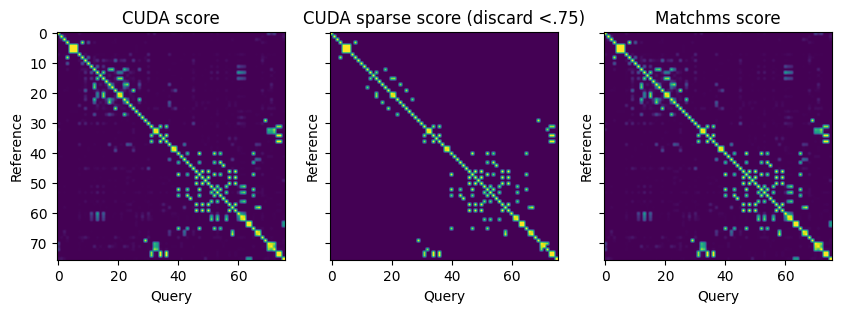

In [54]:
import matplotlib.pyplot as plt

fig, (a,b,c) = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

a.imshow(scores_cu.to_array('CudaCosineGreedy_score'))
a.set_title("CUDA score")

b.imshow(sparse_scores_cu.to_array('CudaCosineGreedy_sparse_score'))
b.set_title("CUDA sparse score (discard <.75)")

c.imshow(scores.to_array('CosineGreedy_score'))
c.set_title("Matchms score")

for ax in (a,b,c):
  ax.set_xlabel('Query')
  ax.set_ylabel('Reference')


We use the CUDA-calculated results in the same fashion:

In [55]:
# This computed all-vs-all similarity scores, the array of which can be accessed as scores.scores
print(f"Size of matrix of computed similarities: {scores_cu.scores.shape}")

# Matchms allows to get the best matches for any query using scores_by_query
query = spectrums[15]  # just an example
best_matches_cu = scores_cu.scores_by_query(query, 'CudaCosineGreedy_score', sort=True)

Size of matrix of computed similarities: (76, 76, 3)


In [56]:
# Print the calculated scores_cu for each spectrum pair
for (reference, (score, matches, overflow)) in best_matches_cu[:10]:
    # Ignore scores_cu between same spectrum
    if reference != query:
        print(f"Reference scan id: {reference.metadata['scans']}")
        print(f"Query scan id: {query.metadata['scans']}")
        print(f"Score: {score:.4f}")
        print(f"Number of matching peaks: {matches}")
        print(f"Did GPU overflow at this pair: {overflow}")
        print("----------------------------")


Reference scan id: 613
Query scan id: 2161
Score: 0.8646
Number of matching peaks: 14
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 603
Query scan id: 2161
Score: 0.8237
Number of matching peaks: 14
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 2160
Query scan id: 2161
Score: 0.8015
Number of matching peaks: 25
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 2362
Query scan id: 2161
Score: 0.2923
Number of matching peaks: 7
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 2598
Query scan id: 2161
Score: 0.2231
Number of matching peaks: 5
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 2594
Query scan id: 2161
Score: 0.1761
Number of matching peaks: 3
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 1944
Query scan id: 2161
Score: 0.1396
Number of matching peaks: 5
Did GPU overflow at this 

We make sure that results from both matchms and CudaCosineGreedy are equal.

In [57]:
for a, b in zip(best_matches[:10], best_matches_cu[:10]):
    reference, (score_a, matches_a) = a
    reference, (score_b, matches_b, overflow_b) = b
    if reference != query:
        # If we didn't overflow
        if not overflow_b:
            assert np.isclose(score_a, score_b), ("score error", score_a, score_b)
            assert np.isclose(matches_a, matches_b), ('match error', matches_a, matches_b)
        # If overflow, score must be leq
        else:
            assert score_a >= score_b
            assert matches_a >= matches_b